# Loading data

In [1]:
import uproot as up
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('seaborn-v0_8-paper')
plt.rcParams["patch.force_edgecolor"] = True

In [2]:
all_feature = pd.read_csv("../../../../mnt/fcufino/all_features.csv")

# Balancing the dataset

In [3]:
print("BKG: ", all_feature["delta_time"][all_feature['Label']==0].shape[0])
print("IBD: ", all_feature["delta_time"][all_feature['Label']==1].shape[0]) 

BKG:  1000081
IBD:  1468385


In [4]:
# Elimina gli elementi desiderati dal dataset
num_IBD = all_feature["delta_time"][all_feature['Label']==1].shape[0]
num_BKG = all_feature["delta_time"][all_feature['Label']==0].shape[0]

del_BKG = 0
del_IBD = 0

if num_IBD > num_BKG:
    del_IBD = num_IBD - num_BKG
    to_del_ibd = all_feature.shape[0] - del_IBD
    order = np.argsort(all_feature["Label"])
    all_feature = all_feature.iloc[order].dropna()
    all_feature = all_feature.iloc[:to_del_ibd]

elif num_IBD < num_BKG:
    del_BKG = num_BKG - num_IBD
    order = np.argsort(all_feature["Label"])
    all_feature = all_feature.iloc[order].dropna()
    all_feature = all_feature.iloc[del_BKG:]

print("BKG:", all_feature["Label"][all_feature['Label']==0].shape[0]) 
print("IBD:",  all_feature["Label"][all_feature['Label']==1].shape[0])

BKG: 1000081
IBD: 1000081


## Creating train and test datasets

In [5]:
from sklearn.model_selection import train_test_split


columns_to_exclude = ['Label', 'Source']


X = all_feature.drop(columns_to_exclude, axis=1)
Y = all_feature['Label']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2)

## PyTorch Neural Network

In [6]:
type(X_train[1:1+4].values)

numpy.ndarray

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import accuracy_score

# cuda, se disponibile
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definire il DataSet personalizzato
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_normed = scaler.transform(X_train)
X_test_normed = scaler.transform(X_test)
    
# Creare i set di dati personalizzati
train_dataset = CustomDataset(torch.from_numpy(X_train_normed).float(), torch.from_numpy(y_train.values).long())
test_dataset = CustomDataset(torch.from_numpy(X_test_normed).float(), torch.from_numpy(y_test.values).long())

# Creare i DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [21]:
import os
from tqdm import tqdm

# Definire la rete neurale
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)  # num features from X_train
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, len(y_train.unique()))  # num classes from y_train

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Istanziare la rete e spostarla su cuda  
net = Net().to(device)

# Definire la loss function e l'optimizer
criterion = nn.CrossEntropyLoss()  # Usando la CrossEntropy come funzione di perdita per la classificazione
optimizer = optim.Adam(net.parameters())

model_path = "torch_net_normed_100ep.pth"
# model_path = "torch_net_normed_def.pth"


# Controllare se esiste un file contenente il modello addestrato
if os.path.isfile(model_path):
    # Caricare il modello
    net.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    net.eval()
    print("Model loaded")
else:
    # Addestrare la rete
    for epoch in tqdm(range(100)):  # 100 epoche
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    print('Finished Training')

    # Salvare il modello
    torch.save(net.state_dict(), model_path)

# Calcolare l'accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs) 
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test data: %d %%' % (100 * correct / total))


Model loaded
Accuracy of the network on the test data: 99 %


# R vs $\Delta R$

17600


Text(0, 0.5, '$\\Delta$t [ns]')

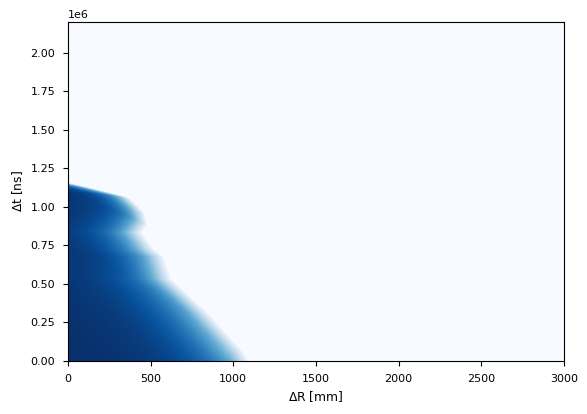

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as nnf

to_plot = pd.DataFrame()
dr_array = np.linspace(0, 3000, 1000)
# dt_array = np.linspace(0, 20*220e3, 1000)
dt_array = np.linspace(0, 10*220e3, 1000)
# dr_array = np.linspace(0, 3000, 1000)
# dt_array = np.linspace(0, 20*220e3, 1000)
dr_mesh, dt_mesh = np.meshgrid(dr_array, dt_array)
elements = len(dr_mesh.flatten())

Radius = np.linspace(0,17600,100).astype(int)
R = Radius[99]
print(R)


to_plot['R_prompt'] = R*np.ones(elements)
to_plot['R_delayed'] = R*np.ones(elements)
to_plot['E_pro'] = 1.*np.ones(elements)
to_plot['delta_radius'] = dr_mesh.flatten()
to_plot['E_del'] = 2.2*np.ones(elements)
to_plot['delta_time'] = dt_mesh.flatten()
to_plot = to_plot[X.columns]
to_plot = scaler.transform(to_plot)

#utilizza net per fare previsione sui dati contenuti in to_plot.
to_plot_tensor = torch.tensor(to_plot, dtype=torch.float32).to('cpu')
probs = net(to_plot_tensor.to('cuda:0')).to('cpu')
probs_normed = nnf.softmax(probs, dim=1).to('cpu')
probs_normed = probs_normed[:, 1].reshape(dr_mesh.shape)
plt.imshow(probs_normed.detach().numpy(), cmap = 'Blues', origin = 'lower', extent = (dr_mesh.min(), dr_mesh.max(), dt_mesh.min(), dt_mesh.max()), aspect = 'auto', vmin = 0.95, vmax = 1)
plt.xlabel(r'$\Delta$R [mm]')
plt.ylabel(r'$\Delta$t [ns]')

   

/tmp/ipykernel_650770/605554521.py:25: UserWarning: The following kwargs were not used by contour: 'aspect'
  plt.contour(probs_normed.detach().numpy(), cmap = 'Blues', origin = 'lower', extent = (dr_mesh.min(), dr_mesh.max(), R_mesh.min(), R_mesh.max()), aspect = 'auto')


Text(0, 0.5, 'R [mm]')

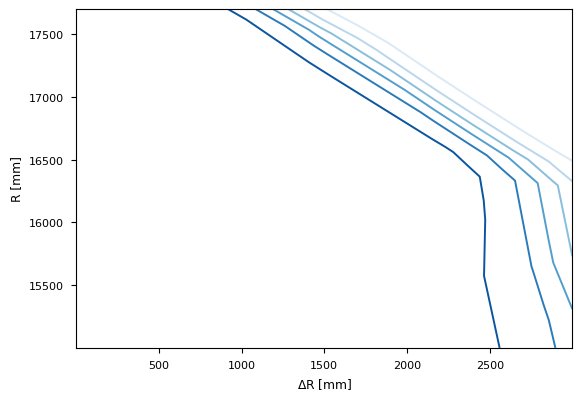

In [35]:
to_plot = pd.DataFrame()

dr_array = np.linspace(0, 3000, 1000)
R_array = np.linspace(15000, 17700, 1000)

dr_mesh, R_mesh = np.meshgrid(dr_array, R_array)

elements = len(dr_mesh.flatten())
to_plot['R_prompt'] = R_mesh.flatten()
to_plot['R_delayed'] = to_plot['R_prompt']
to_plot['E_pro'] = 1.*np.ones(elements)
to_plot['delta_radius'] = dr_mesh.flatten()
to_plot['E_del'] = 2.2*np.ones(elements)
to_plot['delta_time'] = 220e3
to_plot = to_plot[X.columns]
to_plot = scaler.transform(to_plot)


#utilizza net per fare previsione sui dati contenuti in to_plot.
to_plot_tensor = torch.tensor(to_plot, dtype=torch.float32).to('cpu')
probs = net(to_plot_tensor.to('cuda:0')).to('cpu')
probs_normed = nnf.softmax(probs, dim=1).to('cpu')
probs_normed = probs_normed[:, 1].reshape(dr_mesh.shape)

plt.contour(probs_normed.detach().numpy(), cmap = 'Blues', origin = 'lower', extent = (dr_mesh.min(), dr_mesh.max(), R_mesh.min(), R_mesh.max()), aspect = 'auto')

plt.xlabel(r'$\Delta$R [mm]')
plt.ylabel(r'R [mm]')